<a href="https://colab.research.google.com/github/InhyeokYoo/Pytorch-study/blob/master/Ch%207.%20%ED%95%99%EC%8A%B5%20%EC%8B%9C%20%EC%83%9D%EA%B8%B8%20%EC%88%98%20%EC%9E%88%EB%8A%94%20%EB%AC%B8%EC%A0%9C/%208.%20Batch_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Batch Normalization

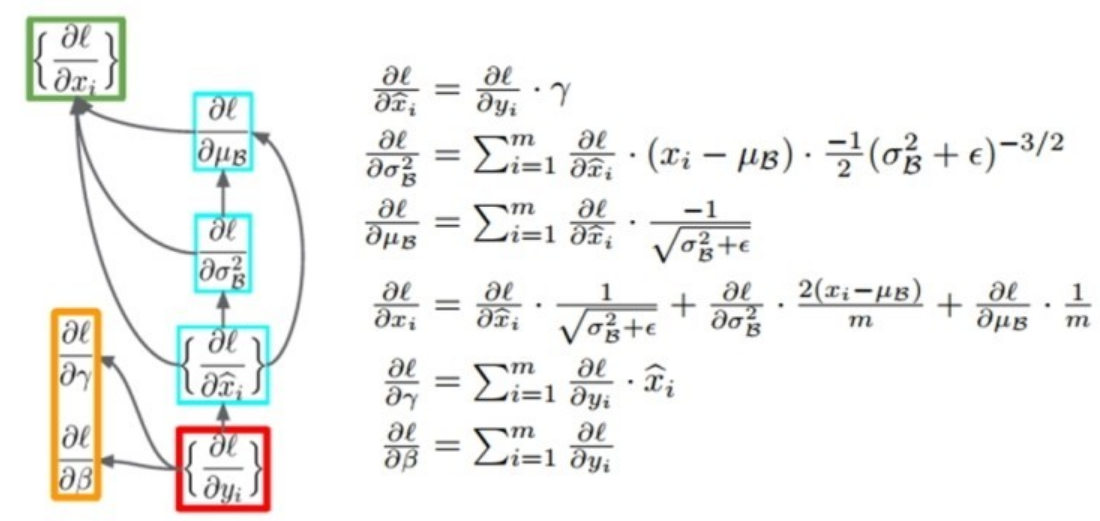

# 1. Setting

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [0]:
# Hyperparameters
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

# 2. Data

In [0]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21949336.83it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


32768it [00:00, 330713.61it/s]
0it [00:00, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 5277616.35it/s]                           
8192it [00:00, 132253.56it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


In [0]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

# 3. Model & Optimizer

In [0]:
# Normalize 한 것과 마찬가지로, layer의 결과값에 정규화를 시행할 수 있음.
# Batch normalization은 컨볼루션 연산처럼 모델에 한 층으로 구현할 수 있음.
# nn.BatchNorm2d(x) -> x는 입력으로 들어오는 channel의 갯수.
# Q. BatchNorm1d, BatchNorm2d, BatchNorm3d와는 무슨 차이가 있는가??

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

만약 Batch Normalization을 CNN에 적용시키고 싶을 경우, 다른 방법을 이용해야만 한다.  

먼저, convolution layer에서 보통 activation function에 값을 넣기 전 $Wx+b$ 형태로 weight를 적용시키는데, Batch Normalization을 사용하고 싶을 경우 normalize 할 때 **$\eta$ 값이 $b$의 역할을 대체할 수 있기 때문에 b를 없애준다.** *(Q. 왜 CNN에서만 $\beta$가 $b$의 역할을 대체하는가?)* 

또한, CNN의 경우 convolution의 성질을 유지시키고 싶기 때문에, 각 channel을 기준으로  각각의 Batch Normalization 변수들을 만든다.  
예를 들어 m의 mini-batch-size, n의 channel size 를 가진 Convolution Layer에서 Batch Normalization을 적용시킨다고 해보자. convolution을 적용한 후의 feature map의 사이즈가 p x q 일 경우, 각 채널에 대해 m x p x q 개의 각각의 스칼라 값에 대해 mean과 variance를 구하는 것이다. 최종적으로 gamma와 beta는 각 채널에 대해 한개씩 해서 총 n개의 독립적인 Batch Normalization 변수들이 생기게 된다.


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cuda:0


# 4. Train

In [0]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)                

tensor(1.6747, device='cuda:0', grad_fn=<NllLossBackward>)


In [0]:
correct = 0
total = 0

# 배치정규화나 드롭아웃은 학습할때와 테스트 할때 다르게 동작하기 때문에 모델을 evaluation 모드로 바꿔서 테스트해야합니다.
model.eval()
with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 92.9286880493164


# BN 성능 accelerating 하기
BN을 추가하는 것만으로 성능 개선이 엄청나게 일어나는 것은 아니므로, 다음과 같은 parameter tuning과정이 추가로 필요하다.
1. learning rate를 높힌다. (0.0075 -> 0.045, 2)
2. drop out을 제거한다. (BN이 regularization 효과가 있기 때문이다)
3. L2 weight decay를 줄인다. (BN이 regularization 효과가 있기 때문이다)
4. Learning rate를 decay를 accelerate 한다 (6배 빠르게 더 가속한다)
5. Local response normalization을 제거한다 (BN에는 적합하지 않음. *요새는 거의 안쓰는 듯*)
6. Training example의 per-batch shuffling을 제거한다 (BN이 regularization을 증폭하기 위함)
7. Photometric distortion을 줄인다. (BN이 속도가 더 빠르고, 더 적은 train example을 보게되어 실제 데이터에 더 집중한다. *이건 Data augmentation 쪽인듯*)